In [1]:
import os
import sys

os.chdir("../..")
sys.path.append("..")

In [2]:
import random
import time
import yaml
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.loader import TrainDataLoader, ValidationDataLoader
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.time_feature import (
    HourOfDay,
    DayOfWeek,
    DayOfMonth,
    DayOfYear,
    MonthOfYear
)
from gluonts.torch.batchify import batchify
from gluonts.transform import (
    AddObservedValuesIndicator,
    AddTimeFeatures,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    ValidationSplitSampler
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm

from src.app.utils import get_prediction_dataloader
from src.models.utils import get_model
from src.utils.data_loading import load_features, load_score, load_test_data, load_train_data
from src.utils.evaluation import score_batch
from src.utils.features import trend_determination, trend_slope, trend_linearity, seasonal_determination, decomps_and_features
from src.utils.transformations import manipulate_trend_component, manipulate_seasonal_determination

/anaconda/envs/whatif/lib/python3.8/site-packages/gluonts/json.py:45: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
model_name = "nbeats_g"
dataset = "m4_weekly"

datadir = f"data/{dataset}"
experiment_dir = f"experiments/{dataset}/{model_name}"
generated_datadir = os.path.join(f"/datadrive2/whatif/{dataset}", "generated", "test")
metric = "mase"

In [4]:
with open(os.path.join(experiment_dir, "config.yaml"), "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [5]:
score = load_score(experiment_dir, metric)
score.shape

(359, 13)

In [6]:
def generate_data(dataset, config):
    test_data = load_test_data(dataset, config["context_length"] + config["prediction_length"])
    
    trend_str_inc_ts = []
    trend_str_dec_ts = []
    trend_lin_inc_ts = []
    trend_lin_dec_ts = []
    trend_slope_inc_ts = []
    trend_slope_dec_ts = []
    seas_str_inc_ts = []
    seas_str_dec_ts = []

    trend_str_inc_feat = []
    trend_str_dec_feat = []
    trend_lin_inc_feat = []
    trend_lin_dec_feat = []
    trend_slope_inc_feat = []
    trend_slope_dec_feat = []
    seas_str_inc_feat = []
    seas_str_dec_feat = []
    for ts in tqdm(test_data):
        decomp = decomps_and_features([ts], config["sp"])[0][0]
        
        inc_str = manipulate_trend_component(decomp.trend, f=2, g=1, h=1, m=0)
        dec_str = manipulate_trend_component(decomp.trend, f=0.01, g=1, h=1, m=0)
        
        inc_lin = manipulate_trend_component(decomp.trend, f=1, g=1, h=2, m=0)
        dec_lin = manipulate_trend_component(decomp.trend, f=1, g=1, h=0.01, m=0)
        
        inc_slope = manipulate_trend_component(decomp.trend, f=1, g=1, h=1, m=-1)
        dec_slope = manipulate_trend_component(decomp.trend, f=1, g=1, h=1, m=1)
        
        generated_ts = [inc_str, dec_str, inc_lin, dec_lin, inc_slope, dec_slope]
        if config["sp"] > 1:
            inc_seas = manipulate_seasonal_determination(decomp.seasonal, k=2)
            dec_seas = manipulate_seasonal_determination(decomp.seasonal, k=0.01)
            generated_ts.extend([inc_seas, dec_seas])
            
        _, features = decomps_and_features(generated_ts, config["sp"])
        
        trend_str_inc_ts.append(inc_str)
        trend_str_dec_ts.append(dec_str)
        trend_lin_inc_ts.append(inc_lin)
        trend_lin_dec_ts.append(dec_lin)
        trend_slope_inc_ts.append(inc_slope)
        trend_slope_dec_ts.append(dec_slope)
        
        trend_str_inc_feat.append(features[0])
        trend_str_dec_feat.append(features[1])
        trend_lin_inc_feat.append(features[2])
        trend_lin_dec_feat.append(features[3])
        trend_slope_inc_feat.append(features[4])
        trend_slope_dec_feat.append(features[5])
        
        if config["sp"] > 1:
            seas_str_inc_ts.append(inc_seas)
            seas_str_dec_ts.append(dec_seas)
            seas_str_inc_feat.append(features[6])
            seas_str_dec_feat.append(features[7])
    
    ts_dict = {"str_inc": trend_str_inc_ts, "str_dec": trend_str_dec_ts,
               "lin_inc": trend_lin_inc_ts, "lin_dec": trend_lin_dec_ts,
               "slope_inc": trend_slope_inc_ts, "slope_dec": trend_slope_dec_ts,
               "seas_inc": seas_str_inc_ts, "seas_dec": seas_str_dec_ts}
    
    feat_dict = {"str_inc": trend_str_inc_feat, "str_dec": trend_str_dec_feat,
                "lin_inc": trend_lin_inc_feat, "lin_dec": trend_lin_dec_feat,
                "slope_inc": trend_slope_inc_feat, "slope_dec": trend_slope_dec_feat,
                "seas_inc": seas_str_inc_feat, "seas_dec": seas_str_dec_feat}
    
    return ts_dict, feat_dict

In [7]:
generated_data, generated_features = generate_data(dataset, config)

 31%|███▏      | 113/359 [00:00<00:00, 1124.94it/s]

Loading test data


100%|██████████| 359/359 [00:10<00:00, 34.10it/s]


### Can we use the already generated data to find out of distribution samples and use those as testing?

In [8]:
train_features = load_features(datadir, train=True)
test_features = load_features(datadir, train=False)
train_features.shape, test_features.shape

((25600, 4), (359, 4))

In [9]:
gen_features = np.array(generated_features["slope_inc"])
gen_features.shape

(359, 4)

In [10]:
scaler = StandardScaler()
norm_train_features = scaler.fit_transform(train_features)
norm_test_features = scaler.transform(test_features)
norm_gen_features = scaler.transform(gen_features)

pca = PCA(n_components=2)
train_pca_data = pca.fit_transform(norm_train_features)
test_pca_data = pca.transform(norm_test_features)
gen_pca_data = pca.transform(norm_gen_features)

(-10.0, 10.0)

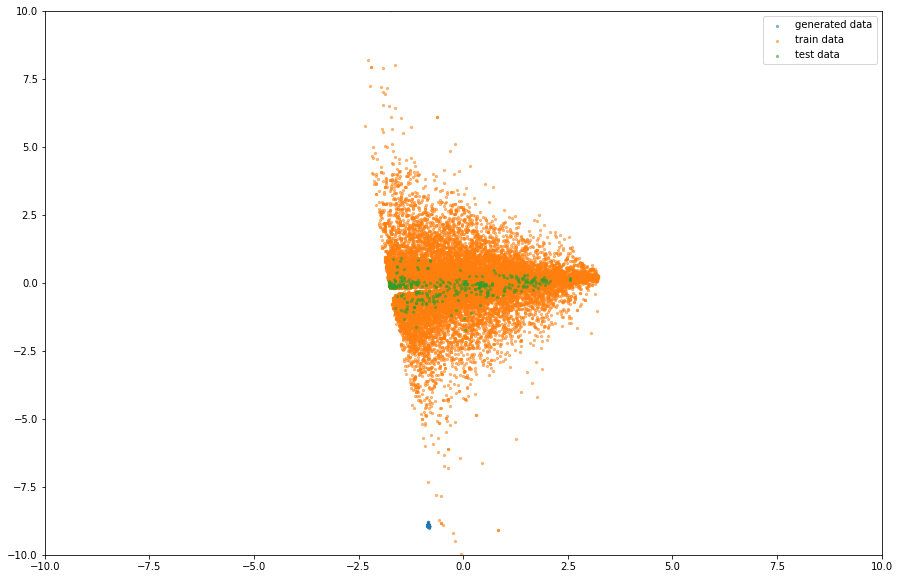

In [11]:
plt.figure(figsize=(15, 10))

plt.scatter(gen_pca_data[:, 0], gen_pca_data[:, 1], label="generated data", s=5, alpha=0.5)
plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="train data", s=5, alpha=0.5)
plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=0.5)
plt.legend()
plt.xlim([-10, 10])
plt.ylim([-10, 10])

In [12]:
def sample_and_plot_from_dataloader(dataloader, sp, scaler, pca, train_pca_data, test_pca_data, num_samples=20000, lim=True):
    sampled_series = []
    for batch in dataloader:
        data = torch.cat([batch["past_target"], batch["future_target"]], dim=-1)
        for ts in data:
            sampled_series.append(pd.Series(ts))

        if len(sampled_series) > num_samples:
            break
    
    _, sampled_features = decomps_and_features(sampled_series, sp)
    sampled_scaled_features = scaler.transform(sampled_features)
    sampled_pca_data = pca.transform(sampled_scaled_features)

    plt.figure(figsize=(15, 10))
    
    if train_pca_data is not None:
        plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="train data", s=5, alpha=.1)
    if test_pca_data is not None:
        plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=.1)
    
    plt.scatter(sampled_pca_data[:, 0], sampled_pca_data[:, 1], label="transformed train data", s=5, alpha=.1, color="r")
    plt.legend()
    
    if lim:
        plt.xlim([-10, 10])
        plt.ylim([-10, 10])
    
    return sampled_series

In [13]:
def create_train_dataloader(dataset, context_length, prediction_length, batch_size, num_batches_per_epoch):
    transformation = Chain([
        AddObservedValuesIndicator(
            target_field=FieldName.TARGET,
            output_field=FieldName.OBSERVED_VALUES,
        ),
        AddTimeFeatures(
            start_field=FieldName.START,
            target_field=FieldName.TARGET,
            output_field=FieldName.FEAT_TIME,
            pred_length=prediction_length,
            time_features=[HourOfDay(), DayOfWeek(), DayOfMonth(), DayOfYear(), MonthOfYear()]
        ),
        InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ExpectedNumInstanceSampler(num_instances=1, min_past=context_length,
                                                        min_future=prediction_length),
            past_length=context_length,
            future_length=prediction_length,
            time_series_fields=[FieldName.FEAT_TIME, FieldName.OBSERVED_VALUES]
        )
    ])
    dataloader = TrainDataLoader(
        dataset,
        batch_size=batch_size,
        stack_fn=batchify,
        transform=transformation,
        num_batches_per_epoch=num_batches_per_epoch,
        num_workers=1
    )
    return dataloader

In [14]:
def create_validation_dataloader(dataset, context_length, prediction_length, batch_size, num_batches_per_epoch):
    transformation = Chain([
        AddObservedValuesIndicator(
            target_field=FieldName.TARGET,
            output_field=FieldName.OBSERVED_VALUES,
        ),
        AddTimeFeatures(
            start_field=FieldName.START,
            target_field=FieldName.TARGET,
            output_field=FieldName.FEAT_TIME,
            pred_length=prediction_length,
            time_features=[HourOfDay(), DayOfWeek(), DayOfMonth(), DayOfYear(), MonthOfYear()]
        ),
        InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ValidationSplitSampler(min_future=prediction_length),
            past_length=context_length,
            future_length=prediction_length,
            time_series_fields=[FieldName.FEAT_TIME, FieldName.OBSERVED_VALUES]
        )
    ])
    dataloader = ValidationDataLoader(
        dataset,
        batch_size=batch_size,
        stack_fn=batchify,
        transform=transformation,
        num_workers=1
    )
    return dataloader

In [15]:
def get_train_and_val_data(dataset, num_validation_windows, context_length, prediction_length):
    train_data = ListDataset(list(iter(dataset.train)), freq=dataset.metadata.freq)
    validation_data = []
    for i in range(num_validation_windows):
        for ts in train_data.list_data:
            # only add time series long enough that we can remove one horizon and still have context_length +
            # prediction_length values left
            if len(ts["target"]) <= context_length + prediction_length * (i + 2):
                continue

            val_ts = deepcopy(ts)
            val_ts["target"] = val_ts["target"][:-prediction_length * i if i > 0 else None]
            val_ts["target"] = val_ts["target"][-(context_length + prediction_length):]
            validation_data.append(val_ts)

            # slice off the validation data from the training data
            if i == num_validation_windows - 1:
                ts["target"] = ts["target"][:-prediction_length * (i + 1)]
    
    return train_data, ListDataset(validation_data, freq=dataset.metadata.freq)

In [16]:
def add_to_dataset(original_data, generated_data):
    for i, ts in enumerate(generated_data):
        entry = {"start": ts.index[0], "target": ts.values, "feat_static_cat": np.array([i]), "item_id": i}
        original_data.list_data.append(entry)
    
    return original_data

In [17]:
def change_trend_lin(data, sp, h):
    generated = []
    for i, ts in tqdm(enumerate(data)):
        index = pd.date_range(start=ts["start"], freq=ts["start"].freq, periods=len(ts["target"]))
        ts = pd.Series(data=ts["target"], index=index)
        decomp = decomps_and_features([ts], config["sp"])[0][0]
        
        new_trend = manipulate_trend_component(decomp.trend, f=1, g=1, h=h, m=0)
        new_ts = new_trend + decomp.seasonal + decomp.resid
        generated.append(new_ts)
    
    return generated


def change_trend_str(data, sp, f):
    generated = []
    for i, ts in tqdm(enumerate(data)):
        index = pd.date_range(start=ts["start"], freq=ts["start"].freq, periods=len(ts["target"]))
        ts = pd.Series(data=ts["target"], index=index)
        decomp = decomps_and_features([ts], config["sp"])[0][0]
        
        new_trend = manipulate_trend_component(decomp.trend, f=f, g=1, h=1, m=0)
        new_ts = new_trend + decomp.seasonal + decomp.resid
        generated.append(new_ts)
    
    return generated


def change_trend_slope(data, sp, m):
    generated = []
    for i, ts in tqdm(enumerate(data)):
        index = pd.date_range(start=ts["start"], freq=ts["start"].freq, periods=len(ts["target"]))
        ts = pd.Series(data=ts["target"], index=index)
        decomp = decomps_and_features([ts], config["sp"])[0][0]
        
        new_trend = manipulate_trend_component(decomp.trend, f=1, g=1, h=1, m=m)
        new_ts = new_trend + decomp.seasonal + decomp.resid
        generated.append(new_ts)
    
    return generated

In [18]:
dataset = get_dataset(config["dataset"])
train_data, validation_data = get_train_and_val_data(dataset, 1, config["trainer_args"]["context_length"],
                                                     config["trainer_args"]["prediction_length"])

In [19]:
generated_train = change_trend_slope(train_data, config["sp"], m=10)
expanded_train = add_to_dataset(train_data, generated_train)

359it [00:05, 60.88it/s] 


In [20]:
generated_val = change_trend_slope(validation_data, config["sp"], m=1)
expanded_val = add_to_dataset(validation_data, generated_val)

359it [00:01, 188.03it/s]


In [21]:
train_dataloader = create_train_dataloader(expanded_train, config["trainer_args"]["context_length"], config["trainer_args"]["prediction_length"],
                                           config["trainer_args"]["batch_size"], config["trainer_args"]["num_batches_per_epoch"])

validation_dataloader = create_validation_dataloader(expanded_val, config["trainer_args"]["context_length"], config["trainer_args"]["prediction_length"],
                                                     config["trainer_args"]["batch_size"], config["trainer_args"]["num_batches_per_epoch"])

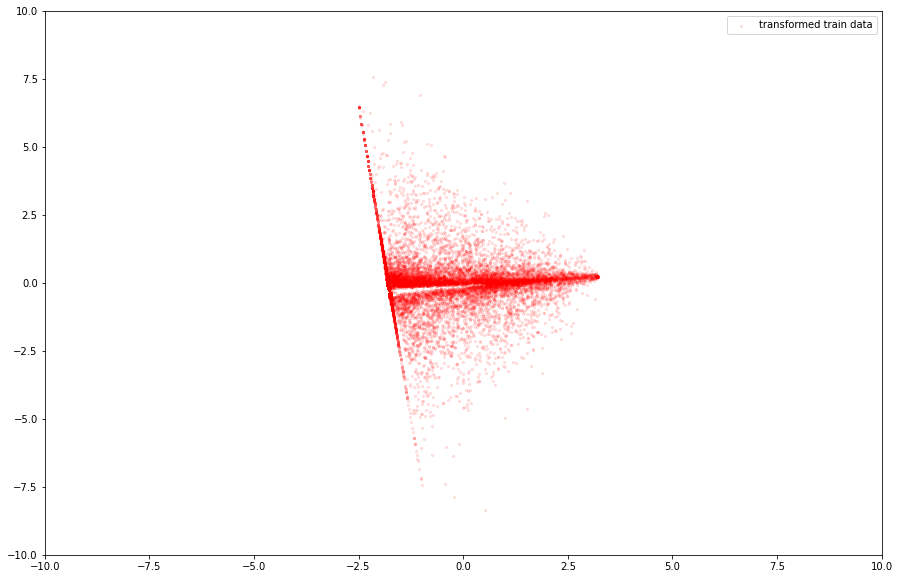

In [22]:
_ = sample_and_plot_from_dataloader(train_dataloader, config["sp"], scaler, pca, None, None)

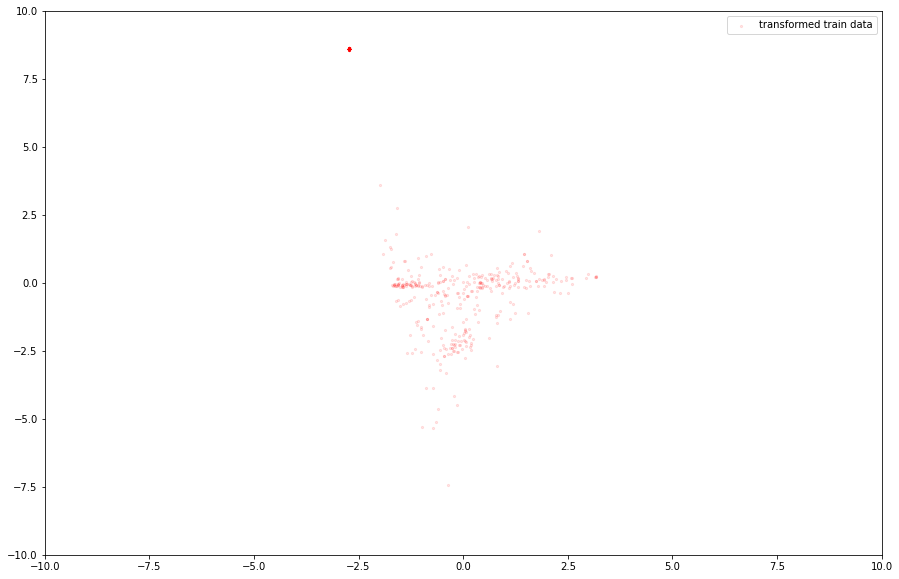

In [23]:
_ = sample_and_plot_from_dataloader(validation_dataloader, config["sp"], scaler, pca, None, None, num_samples=len(expanded_val))